In [2]:
from pandas import read_csv, to_datetime, Series
import numpy as np
import project_functions

In [3]:
# Open data file
df = read_csv('intake_and_outcome_data.csv')

# Replacing all NaN values of name column with "No name"
df["Name"].fillna("No name", inplace=True)

# Converts string dates to datetime dtypes
df["Date Of Birth"] = to_datetime(df["Date Of Birth"])
df["Intake Date"] = to_datetime(df["Intake Date"])
df["Outcome Date"] = to_datetime(df["Outcome Date"])

# Find age in days of animal on intake date if birth date provided
birth_dates = np.array(df["Date Of Birth"], dtype='datetime64[D]')
intake_dates = np.array(df["Intake Date"], dtype='datetime64[D]')
ages = np.array((intake_dates - birth_dates), dtype="int")
ages = np.where(ages < 0, 0, ages) # changes age to zero if born after intake
ages = np.where(np.isnat(birth_dates), np.nan, ages) # gives NaN value if no birthday provided and changes dtype to float64
df['Age In Days'] = ages

# Calculate average age of animals excluding those with unknown birth dates
avg_age_in_years = np.nanmean(ages)/365.24
print(avg_age_in_years)

3.432420600428609


Enter a year between 2014 and 2022 to view number of intakes/outcomes per month:  2020


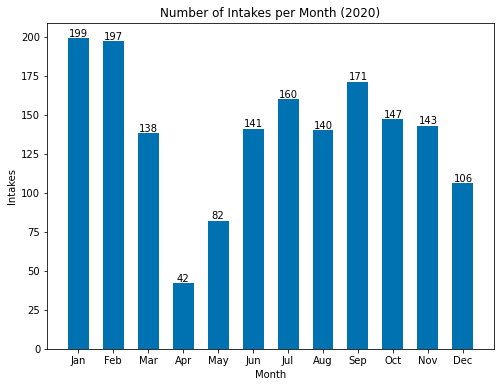

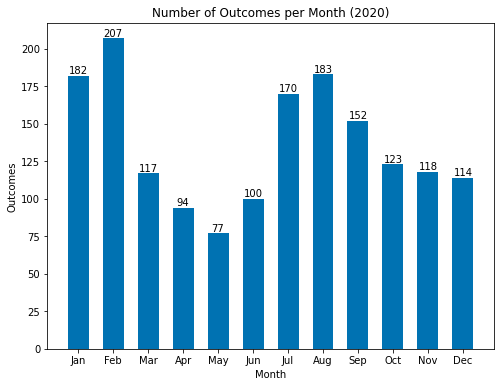

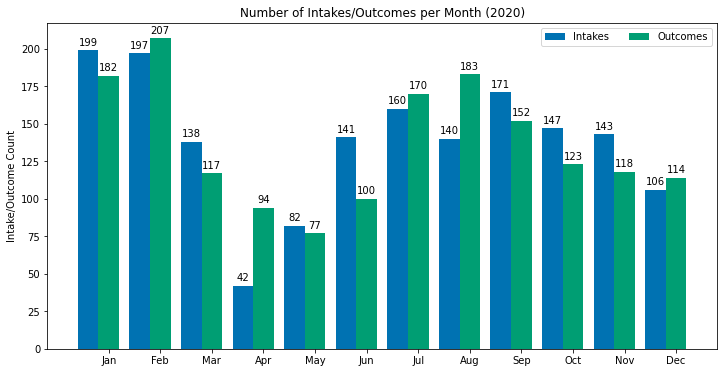

In [4]:
# Find number of intakes by month for specific year
year = input("Enter a year between 2014 and 2022 to view number of "
             "intakes/outcomes per month: ")
while not year.isnumeric() or int(year) > 2022 or int(year) < 2014:
    year = input("Enter a year between 2014 and 2022 to view number of "
                 "intakes/outcomes per month: ")
df_in_date = df[df["Intake Date"].dt.strftime("%Y") == f"{year}"]
total_annual_intakes = len(df_in_date.index)
monthly_intakes = Series.sort_index(df_in_date["Intake Date"].
                                    dt.month.value_counts())

# Find number of outcomes by month for specific year
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]
total_annual_outcomes = len(df_out_date.index)
monthly_outcomes = Series.sort_index(df_out_date["Outcome Date"].
                                     dt.month.value_counts())

# Plot monthly intakes
project_functions.monthly_in_out(monthly_intakes, year, "Intakes")

# Plot monthly outcomes
project_functions.monthly_in_out(monthly_outcomes, year, "Outcomes")

# Plot intakes/outcomes grouped
project_functions.monthly_in_out_grouped(monthly_intakes, monthly_outcomes, year)
